In [1]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#import data
train = pd.read_csv('../../data/raw/Emergent_NAACL2016/emergent/url-versions-2015-06-14-clean-train.csv')
train.drop(columns=["Unnamed: 0"], inplace=True)

In [3]:
#create features
align_feature = pd.read_csv('../../data/processed/features/alignment_feature.csv')
cosine_feature = pd.read_csv('../../data/processed/features/cosine_feature.csv')
bow_feature = pd.read_csv('../../data/processed/features/headline_BoWBigram.csv')
qmark_feature = pd.read_csv('../../data/processed/features/headline_Qmark.csv')
neg_alignment_feature = pd.read_csv('../../data/processed/features/neg_alignment_feature.csv')
root_dist_feature = pd.read_csv('../../data/processed/features/root_dist_min.csv')
svo_feature = pd.read_csv('../../data/processed/features/svo_Lexical.csv')

In [4]:
target_map = {"for": 0, "observing": 1, "against": 2}

In [5]:
train = train.replace({"articleHeadlineStance": target_map})

In [6]:
train["articleHeadlineStance"].value_counts()

0    992
1    775
2    304
Name: articleHeadlineStance, dtype: int64

In [7]:
train = pd.merge(train, align_feature, on="articleId")
train = pd.merge(train, cosine_feature, on="articleId")
train = pd.merge(train, bow_feature, on="articleId")
train = pd.merge(train, qmark_feature, on="articleId")
train = pd.merge(train, neg_alignment_feature, on="articleId")
train = pd.merge(train, root_dist_feature, on="articleId")
train = pd.merge(train, svo_feature, on="articleId")

In [8]:
train["articleHeadlineStance"] = train["articleHeadlineStance"].astype("int")

In [9]:
# merge datasets and shuuffle with random seed
seed = 1234

train = sklearn.utils.shuffle(train, random_state=seed)



In [12]:
# create train.
X_train = train.to_numpy()[:,5:]
Y_train = train["articleHeadlineStance"].values.reshape((-1,))

In [15]:
Y_train = Y_train
X_train = X_train.astype(float)

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

# Import some data to play with
X = X_train
y = Y_train

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

In [18]:
max_iter = 10e2
C=0.8
penalty='l1'

# Normal Train and Test

from sklearn.linear_model import LogisticRegression
#soln = LogisticRegression(penalty=penalty, C=C, max_iter = max_iter, multi_class='auto', solver="liblinear")
#soln = soln.fit(X_train,Y_train)
#ypred = soln.predict(X_val)


In [19]:
# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0)
# Learn to predict each class against the other
classifier = OneVsRestClassifier(LogisticRegression(penalty=penalty, C=C, max_iter = max_iter, multi_class='auto', solver="liblinear"))


In [20]:
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

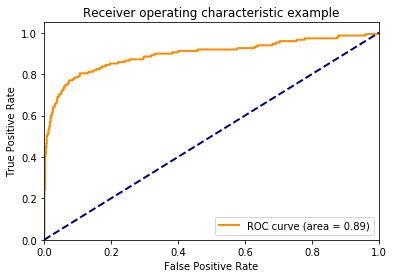

In [21]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()